<a href="https://colab.research.google.com/github/de-abreu/text_annotation/blob/main/Experiment_on_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment on text classification



## Purpose

To make use of preset prompt designs to augument and, to some extent, automatize every phase of an text annotation pipeline: from its preparation of its data to the analysis of results obtained from it.

The process of development is oriented using the TTD (Test Driven Development) methodology.

## Installation and instantiation of required packages

Install additional libraries, that are not available by default on Google Colab:

- **langchain_community:** Allows to take models from Hugging Face and have them be executed locally.

- **toml:** Enables the parsing of files or strings written using toml syntax to be parsed into python dictionaries.

In [1]:
# Install additional libraries

!pip install langchain_community==0.3.21 toml==0.10.2

Loading of required libraries

In [2]:
from google.colab import userdata
from huggingface_hub import login
from langchain.llms import HuggingFacePipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from transformers import pipeline
from transformers.models.auto.modeling_auto import AutoModelForCausalLM
from transformers.models.auto.tokenization_auto import AutoTokenizer
import accelerate
import gc
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import tomllib
import torch

## Accessing Hugging Face and loading dataset to be evaluated

In [3]:
login(token=userdata.get('HF_TOKEN'))
try:
  df = pd.read_csv('train_split1.csv')
  print(df.head(10))
except FileNotFoundError:
  print("Error: 'train_split1.csv' not found in the current directory.")
  exit()

                                                text           label
0  #USER# #USER# Because…..\n\nAs with everything...          Desire
1  #USER# #USER# #USER# #USER# #USER# The world i...          Desire
2  Manna to commence US last-mile drone delivery ...          Desire
3  Sen. Blackburn sounds like someone who is hopi...        Not-Hope
4  #USER# Me a bear casually hoping I bump into y...          Desire
5  that kind of torture is obscene and those invo...          Belief
6  #USER# #USER# Unless I’m missing something obv...        Not-Hope
7  what it lacks for me is n t available on one p...        Not-Hope
8  Chan... \nWhat I RLLY admire from him and aspi...          Desire
9  #USER# I wish Cali had more of those. Get them...  Counterfactual


## Evaluating dataset for missing values and label distribution

Label Counts:
label
Not-Hope          1599
Desire            1149
Belief             801
Counterfactual     167
Name: count, dtype: int64

Missing Values:
text     0
label    0
dtype: int64




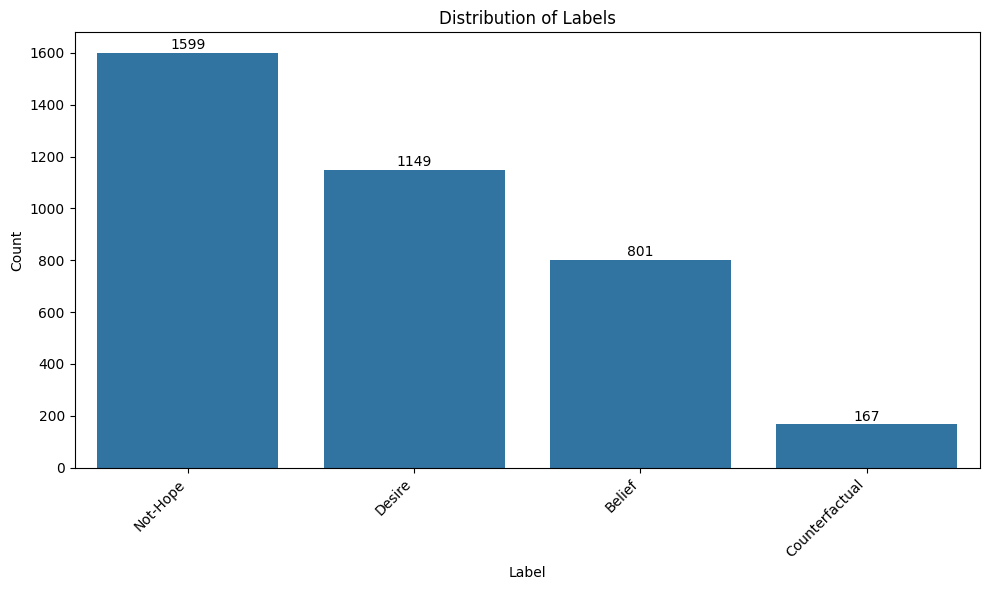

In [4]:
if 'label' not in df.columns:
    print("Error: 'label' column not found in the CSV file.")
    exit()

# Count the occurrence of each label
label_counts = df['label'].value_counts()
missing_values = df.isnull().sum()

print("Label Counts:")
print(label_counts)
print("\nMissing Values:")
print(missing_values)
print("\n")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Annotate each bar with its count
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 3, str(count), ha='center', va='bottom')  # Adjust the '+3' for better visibility

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Here we verify that there are no missing values, but there *is* a very unequal distribution of labels. This suggests the need for data stratification if subsets of the dataset are to be used, as required when spliting data into training, validation and testing sets.

This should be done in later stages of development, after a valid application of the model has been confirmed without any data stratification being present.

## Load LLM and set method to parse responses given in toml format.

In [5]:
model_id = "mistralai/Mistral-7B-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

# Omit warnings about missing padding tokens
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

generator = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    num_return_sequences = 1,
    max_new_tokens = 2048,
    do_sample=True,
    temperature = 0.001,
    top_p = 0.95,
    repetition_penalty = 1.1,
    device=0 if torch.cuda.is_available() else -1
)

llm = HuggingFacePipeline(pipeline=generator)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
<ipython-input-5-4873c033d525>:27: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=generator)


In [7]:
def parse_toml(text: str) -> dict[str, str] | None:
    """
    Extract a ```toml … ``` code block from `text` and parses it.
    Returns:
        dict with the parsed TOML if successful,
        None if extraction or parsing fails.
    """
    # 1) Remove anything up to and including “Answer:”
    body = re.sub(r'(?s)^.*?Answer:\s*', '', text)

    # 2) Grab the first TOML code block
    matches = re.findall(r'(?<=```toml\n)[^`]*?(?=\n```)', body)
    if not matches:                         # no TOML code block
        return None

    toml_snippet = matches[0].strip()

    # 3) Attempt to decode the TOML
    try:
        return tomllib.loads(toml_snippet)
    except tomllib.TOMLDecodeError:         # malformed TOML
        return None
    except Exception:                       # any other unforeseen error
        return None

## Initial prompt, generation of labels and examples

Here the LLM is tasked with generating labels and examples for text annotation, when given a set of criteria. A relationship of equivalence with labels assigned by human annotators is also set.

In [6]:
# Define the LLM prompt format
prompt = """
In the context of text annotation, devise a label to denote a text that fits following description: "{text}"

The label should be a single word, not contained in the following list: "{prev}"

Provide your response in the following toml format:

```toml
label = "<suggested label>"
description = "<explanation of the suggested label>"
example = "<example of text that fits the label description>"
```
Answer:
"""

In [8]:
def get_label(text: str, labels: list[str]) -> dict[str,str]:
  result = llm.invoke(prompt.format(text = text, prev = ", ".join(labels)))
  return parse_toml(result)

labels : dict[str, dict] = {}

for name, description in zip(
    ["Belief", "Counterfactual", "Desire"],
    [
        "expressions in the future/present tense indicating a belief or prediction about what will happen, or how things should be. Often includes anticipations, worldviews, deontic, and epistemic expressions",
        "expressions in the past tense indicating a wish, hope, belief, sorrow for a different outcome or reality.",
        "expressions in the future/present tense indicating a wish, desire, or intention to do something next. Often includes plans or commands (imperatives)."
    ]
  ):
  labels[name] = get_label(description, [labels[x]["label"] for x in labels])
labels['Not-Hope'] = {'label': 'Other', 'description': 'Does not match any of the previous criteria.'}
print(labels)

{'Belief': {'label': 'prediction', 'description': 'expressions in the future/present tense indicating a belief or prediction about what will happen, or how things should be. Often includes anticipations, worldviews, deontic, and epistemic expressions', 'example': "I think it'll rain tomorrow."}, 'Counterfactual': {'label': 'wish', 'description': 'expressions in the past tense indicating a wish, hope, belief, sorrow for a different outcome or reality', 'example': 'I wish I had known you better.'}, 'Desire': {'label': 'intent', 'description': 'expressions in the future/present tense indicating a wish, desire, or intention to do something next. Often includes plans or commands (imperatives).', 'example': "I'm going to go to the store."}, 'Not-Hope': {'label': 'Other', 'description': 'Does not match any of the previous criteria.'}}


## Application of labels to unseen data

This part could have some optimization to address the following warning: "You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset"

In [9]:
labels_string = ""
for _, label_data in labels.items():
    labels_string += f"""
label = {label_data["label"]}
description = {label_data["description"]}
{"example = " + label_data["example"] if "example" in label_data else ""}
"""

prompt = f"""
As an text annotator, your task is to assign one of the following labels:
{labels_string}
""" + """
To the following text: "{text}"

Provide your answer in the following toml format:

```toml
assigned_label = "<assigned label>"
```
Answer:
"""

In [10]:
ai_to_human_label_map = {v['label']: k for k, v in labels.items()}
results = []

for index, row in df.iterrows():
  response = llm.invoke(prompt.format(text = row['text']))
  result = parse_toml(response)
  if result is None:
    print(f"Error parsing response for index {index}: {response}")
    continue
  result['assigned_label'] = ai_to_human_label_map.get(result['assigned_label'], 'Not-Hope')
  result['expected_label'] = row['label']
  results.append(result)

results_df = pd.DataFrame(results)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Results and analysis for first iteration

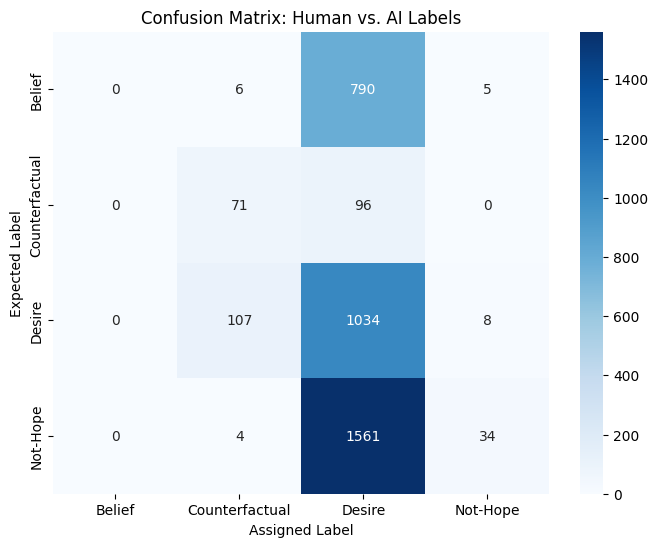

Length of orriginal dataframe: 3716
Length of results dataframe: 3716


In [11]:
conf_mat = confusion_matrix(results_df['expected_label'], results_df['assigned_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels.keys(),
            yticklabels=labels.keys())
plt.xlabel('Assigned Label')
plt.ylabel('Expected Label')
plt.title('Confusion Matrix: Human vs. AI Labels')
plt.show()
print(f"Length of original dataframe: {len(df)}")
print(f"Length of results dataframe: {len(results_df)}")

We have good newls and bad news:

- Good news:
  - Data formatted in toml syntax has been parsed flawlessly, with no loss of data values.

- Bad news:
  - Results are quite a lot off mark, making further iterations to generate more few-shot examples and tweaking label descriptions needed.